In [1]:
from datasets import load_dataset, load_from_disk
import soundfile as sf
import os

# 1. Data preparation
### Download data of <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/en_us">English</a>, <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/ar_eg">Arabic</a>, and <a href="https://huggingface.co/datasets/google/fleurs/tree/main/data/de_de">German</a> languages from <a href="https://huggingface.co/datasets/google/fleurs">Fleurs</a> dataset and save them locally

In [2]:
if not os.path.exists("./data"): 
    data_folder_paths = ["ar_eg", "en_us", "de_de"]
    for data_folder in data_folder_paths:
        # Specify the path where you want to download the folder contents
        download_path = "./data/" + data_folder +"/"
        # Load the dataset
        dataset = load_dataset("google/fleurs", data_folder)
        dataset.save_to_disk(download_path)

### Load the downloaded datasets

In [3]:
eng_dataset = load_from_disk("./data/en_us/")
arb_dataset = load_from_disk("./data/ar_eg/")
ger_dataset = load_from_disk("./data/de_de/")

### Get some insights about the data

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [36]:
mode = "train"    # ===================================> change between train, test, validation and run the cell below
# Define bins for duration 
bins = range(0, 30, 2)  # Bin size of 2 seconds

# Initialize empty lists for duration
durations_eng = []
# Loop through each WAV file in your dataset
for sample in eng_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_eng.append(duration)

durations_df = pd.DataFrame({"Duration":durations_eng, "Language":"eng"})

durations_arb = []  
for sample in arb_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_arb.append(duration)
    
durations_df2 = pd.DataFrame({"Duration":durations_arb, "Language":"arb"})
durations_df = pd.concat([durations_df, durations_df2], ignore_index=True)

durations_ger = []     
for sample in ger_dataset[mode]:
    duration = sample["num_samples"] / sample["audio"]["sampling_rate"]  # Calculate duration in seconds
    durations_ger.append(duration)
    
durations_df2 = pd.DataFrame({"Duration":durations_ger, "Language":"ger"})
durations_df = pd.concat([durations_df, durations_df2], ignore_index=True)

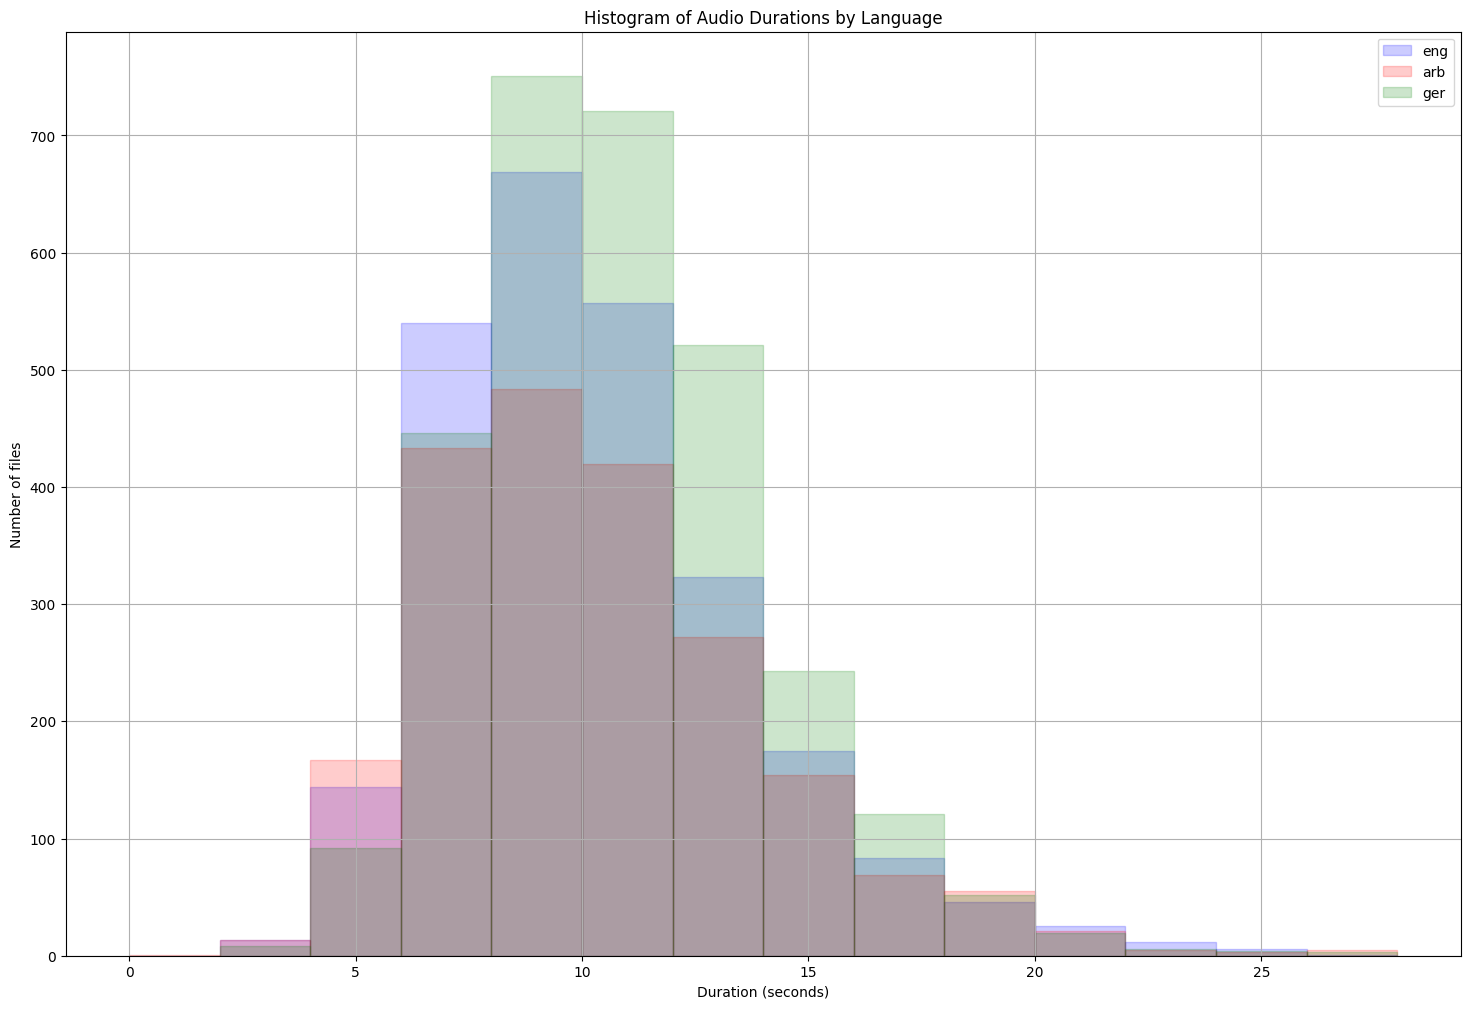

In [37]:
# Create the histogram plot
plt.figure(figsize=(18, 12))
plt.hist(durations_eng, bins, histtype='bar', color="blue", label="eng", alpha=0.2, edgecolor="blue")
plt.hist(durations_arb, bins, histtype='bar', color="red", label="arb", alpha=0.2, edgecolor="red")
plt.hist(durations_ger, bins, histtype='bar', color="green", label="ger", alpha=0.2, edgecolor="green")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of files")
plt.title("Histogram of Audio Durations by Language")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
durations_df.describe()

,Duration
count,7693.000000
mean,10.548216
std,3.532879
min,0.319063
25%,8.100000
50%,10.080000
75%,12.480000
max,42.360000


Remark:
- most of the data in the training set is concentrated at recordings in the range 6-14 seconds recording size
- the same could be said for testing except that of german language it is spread more towards longer recordings
- the validation is centralized in the range 6-12
- from the above description of the training dataset the mean duration is 10.5 and the std is 3.5 so if we take our range [6-14] we will have covered nearly 68% of the population with maintaining a reasonable recording size range

Conclusion:
- we will filter the dataset and take only recordings of durations in range 6-14 seconds

### Apply the filteration

# 1. HMM

In [42]:
# 1. get mel spectrogram
# 2. train the HMM

Note, since the EM algorithm is a gradient-based optimization method, it will generally get stuck in local optima. You should in general try to run fit with various initializations and select the highest scored model.

The score of the model can be calculated by the score() method.

In [23]:
print(eng_dataset)
eng_dataset["train"][0]["audio"]

DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 2602
    })
    validation: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 394
    })
    test: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 647
    })
})


{'path': '10004088536354799741.wav',
 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.15904617e-06, -3.03983688e-06, -3.27825546e-06]),
 'sampling_rate': 16000}

In [24]:

def generate_wav(path, file_name, audio_data, sampling_rate):
    if not os.path.exists(path):
        os.makedirs(path)
    # Save the audio data as a WAV file
    sf.write(path+file_name, audio_data, sampling_rate)


In [25]:
generate_wav("./eng/","eng1.wav", eng_dataset["train"][0]["audio"]["array"], eng_dataset["train"][0]["audio"]["sampling_rate"])
generate_wav("./ger/","ger1.wav", ger_dataset["train"][0]["audio"]["array"], ger_dataset["train"][0]["audio"]["sampling_rate"])
generate_wav("./arb/","arb1.wav", arb_dataset["train"][0]["audio"]["array"], arb_dataset["train"][0]["audio"]["sampling_rate"])
